In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
df = pd.read_csv('../dataset/complete_dataset.csv')
df.dropna(subset=['text', 'titleType'], inplace=True)
df.drop_duplicates(subset='IMDB_ID', inplace=True)

/Users/lennartkeller/opt/anaconda3/envs/clustering/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,1,3,5,6,7,8,9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [112]:
df.dropna(subset=['production_region'], inplace=True)
df['main_region'] = [
    'English' if "English" in list(map(lambda x: re.sub(r'\s+','', x), production_region.split(','))) else "Other" for production_region in df.production_region
]

# Downsample notebook

In [113]:
#df = df.sample(frac=0.5)

In [114]:
df.shape

(3659, 20)

# Feature Extraction

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_union

from stop_words import get_stop_words

uni_tfidf = TfidfVectorizer(max_features=20000,  ngram_range=(1,1), stop_words=get_stop_words('de'))
bi_tfidf = TfidfVectorizer(max_features=20000,  ngram_range=(2, 2), stop_words=get_stop_words('de'))

union = make_union(
    uni_tfidf,
    bi_tfidf,
    n_jobs=-1
)

X = union.fit_transform(df.text)

# Clustering

## DBScan

In [6]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(n_jobs=-1)
db_labels = dbscan.fit_predict(X)

In [8]:
set(db_labels)

{-1}

## KMeans

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_jobs=-1, n_clusters=6)

kmeans_labels = kmeans.fit_predict(X)

/Users/lennartkeller/opt/anaconda3/envs/clustering/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [10]:
kmeans_labels

array([2, 2, 2, ..., 5, 5, 2], dtype=int32)

# Dimensionality Reduction of clustered data

## PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

Xr_pca = pca.fit_transform(X.todense()) 

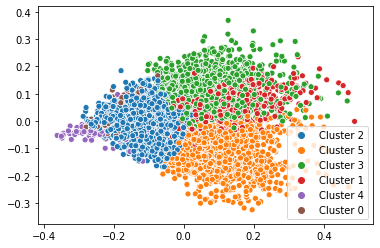

In [12]:
sns.scatterplot(Xr_pca[:,0], Xr_pca[:,1], hue=[f'Cluster {i}' for i in kmeans_labels])

## TruncatedSVC

In [13]:
from sklearn.decomposition import TruncatedSVD

trunc_svd = TruncatedSVD()

Xr_svd = trunc_svd.fit_transform(X) 

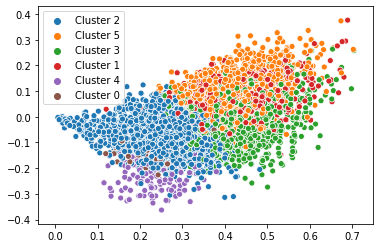

In [14]:
sns.scatterplot(Xr_svd[:,0], Xr_svd[:,1], hue=[f'Cluster {i}' for i in kmeans_labels])

## UMAP

In [15]:
from umap import UMAP

umap = UMAP(n_components=2)

Xr_umap = umap.fit_transform(X)

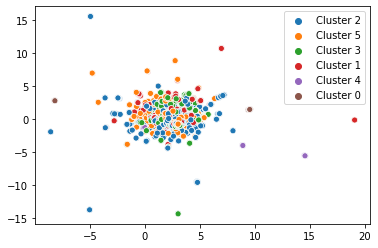

In [16]:
sns.scatterplot(Xr_umap[:,0], Xr_umap[:,1], hue=[f'Cluster {i}' for i in kmeans_labels])

# Test: Try to do a classification of the main regions

In [19]:
from sklearn.svm import LinearSVC

In [115]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df)

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

feat_trans = TfidfVectorizer(stop_words=get_stop_words('de'), max_features=20000)

X_train = feat_trans.fit_transform(df_train.text)
X_test = feat_trans.transform(df_test.text)

In [117]:
y_train = df_train.main_region
y_test = df_test.main_region

In [118]:
clf = LinearSVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [119]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

     English       0.91      0.88      0.89       577
       Other       0.80      0.85      0.83       338

    accuracy                           0.87       915
   macro avg       0.86      0.86      0.86       915
weighted avg       0.87      0.87      0.87       915

0.859801367859481


In [124]:
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
reducer = UMAP(n_components=2, n_neighbors=50)

Xr = reducer.fit_transform(X_test)

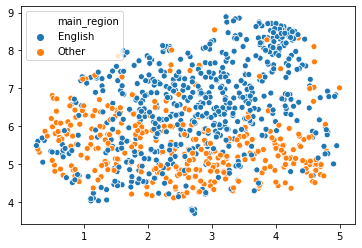

In [125]:
sns.scatterplot(Xr[:,0], Xr[:,1], hue=y_test)